In [48]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [49]:
experiment_name = 'Perceptron 6'
statistics_file = 'D:/experiments/' + experiment_name + '/statistics.json'
with open(statistics_file) as f:
	stat = json.load(f)

def to_numpy(list_of_lists):
	for i in range(0, len(list_of_lists)):
		if len(list_of_lists[i]) > 5:
			list_of_lists[i] = list_of_lists[i][0:5]
	return np.array(list_of_lists)


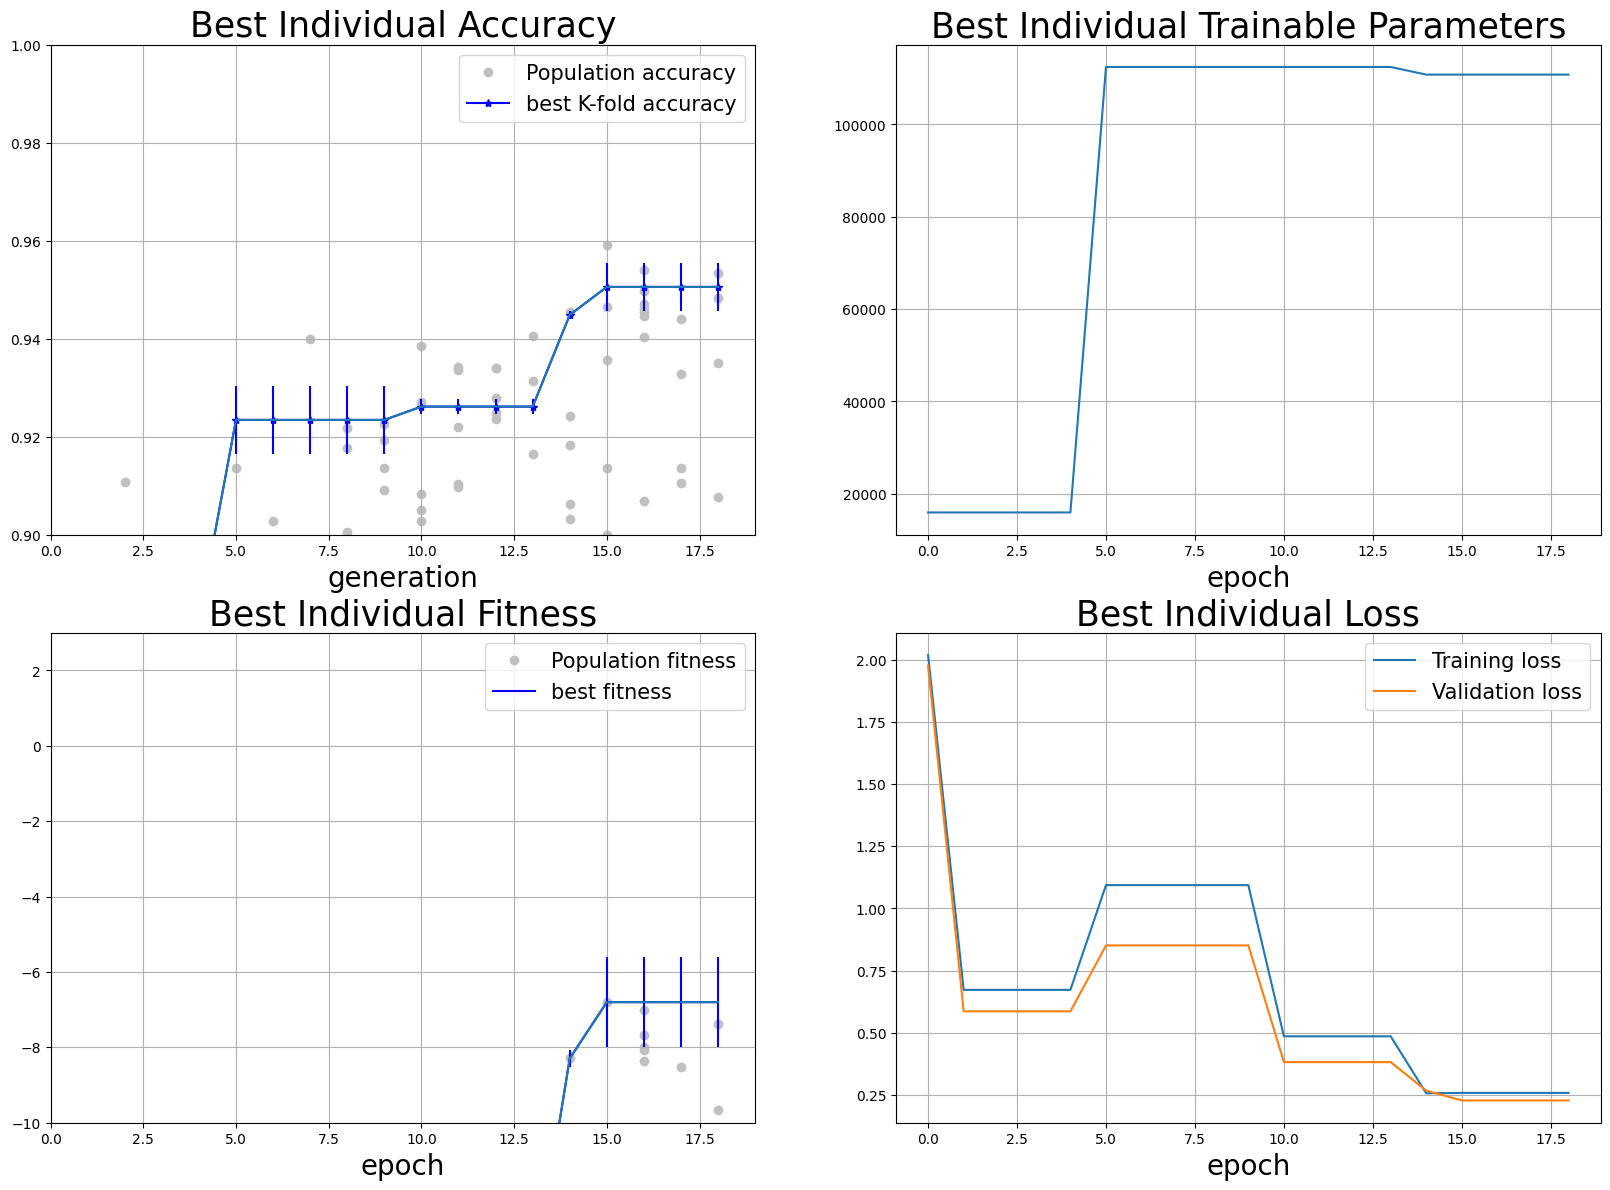

In [50]:
# show label for 'Population accuracy' only once
def reduced_legend(ax, population_size):
	handles, labels = ax.get_legend_handles_labels()
	display = (0,population_size)
	ax.legend([handle for i,handle in enumerate(handles) if i in display],
				[label for i,label in enumerate(labels) if i in display], loc = 'best', fontsize=15)

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,14))

ax.set_title('Best Individual Accuracy', fontsize=25)
ax.set_xlabel("generation", fontsize=20)

generation_accuracy = to_numpy(stat['generation_accuracy'])
(ngenerations, population_size) = generation_accuracy.shape
xscale = np.arange(0, ngenerations)
for i in range(population_size):
	ax.plot(generation_accuracy[:, i], '-',color ='#C0C0C0',label = 'Population accuracy',zorder=-32)
ax.plot(xscale, stat['k_fold_accuracy'], 'b*-', label="K-fold accuracy")
ax.errorbar(xscale, stat['k_fold_accuracy'], yerr = stat['k_fold_accuracy_std'], ecolor='b', zorder=10)
ax.plot(stat['k_fold_final_accuracy'], label="K-fold final accuracy")
#ax.plot(stat['accuracy'], label="test accuracy 0")
#ax.plot(stat['train_accuracy'], label="training accuracy 0")
#ax.plot(stat['val_accuracy'], label="validation accuracy 0")
ax.set_ylim(0.9, 1.0)
ax.set_xlim(0, ngenerations)
reduced_legend(ax, population_size)
ax.grid(True)

ax2.set_title('Best Individual Trainable Parameters', fontsize=25)
ax2.set_xlabel("epoch", fontsize=20)
ax2.plot(stat['parameters'], label="trainable parameters")

ax3.set_title('Best Individual Fitness', fontsize=25)
ax3.set_xlabel("epoch", fontsize=20)
generation_fitness = to_numpy(stat['generation_fitness'])
(ngenerations, population_size) = generation_fitness.shape
xscale = np.arange(0, ngenerations)
for i in range(population_size):
	ax3.plot(generation_fitness[:, i], '-',color ='#C0C0C0',label = 'Population fitness',zorder=-32)
ax3.plot(stat['fitness'], label="Fitness")
ax3.set_ylim(-10, 3)
ax3.set_xlim(0, ngenerations)
reduced_legend(ax3, population_size)
ax3.grid(True)

ax4.set_title('Best Individual Loss', fontsize=25)
ax4.set_xlabel("epoch", fontsize=20)
ax4.plot(stat['train_loss'], label="Training loss")
ax4.plot(stat['val_loss'], label="Validation loss")
ax4.legend(fontsize=15)

ax2.grid(True)
ax4.grid(True)